In [5]:
# 导入必需的库

import numpy as np
import h5py
import matplotlib.pyplot as plt

# 加载自定义的工具类函数
from testCases import *
from dnn_utils import *

# 设置一些绘图相关的参数
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 固定随机数种子
np.random.seed(1)

![](./images/dims1.png)

In [1]:
# 初始化参数函数
# layer_dims 包含每一层的神经元个数 (输入层、第一层、第二层... 输出层)
# 如 [5, 4, 3] 表示输入层有 5 个神经元，第一层有 4 个神经元，最后一层有 3 个神经元

def initialize_parameters_deep(layer_dims):
    # 固定随机数种子
    np.random.seed(1)

    # 初始化好的参数
    parameters = {}

    # 获取神经网络层数 (包含了输入层)
    L = len(layer_dims)

    # 跳过了输入层
    for l in range(1, L):
        # Wl 的维度是 (n[l], n[l-1])
        # np.sqrt(layer_dims[l-1])  为了延缓梯度消失和爆炸，我们需要将权重初始化为更靠近0的数
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])

        # 构建并初始化 b
        # bl 的维度 (n[l], 1)
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        # 核对 w, b 的维度
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters


`linear_forward` 用于实现公式 $Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$， 称之为线性前向传播

In [3]:
# 线性前向传播
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b

    # 核对 Z 的维度
    assert(Z.shape == (W.shape[0], A.shape[1]))

    # 保存 A, W, b
    cache = (A, W, b)

    return Z, cache

`linear_activation_forward` 用于实现公式 $A^{[l]} = g(Z^{[l]})$，g代表激活函数

In [7]:
# 非线性前向传播
# A_prev 上一层的 A
# W 本层的 w
# b 本层的 b
# activation 激活函数, 'sigmoid'/'relu'

def linear_activation_forward(A_prev, W, b, activation):
    # 计算本层的 Z
    Z, linear_cache = linear_forward(A_prev, W, b)

    # 使用激活函数
    if activation == 'sigmoid':
        A = sigmoid(Z)
    elif activation == 'relu':
        A = relu(Z)

    # 核对 A 的维度
    assert (A.shape == (W.shape[0], A_prev.shape[1]))

    # 缓存 Z, linear_cache
    cache = (linear_cache, Z)

    return A, cache

![](./images/forward_propagation.png)

In [11]:
# 前向传播
# 前 L-1 层使用 relu 激活函数，最后一层使用 sigmoid 激活函数
# 输入特征数据 X，每一层的 w, b (parameters)

def L_model_forward(X, parameters):
    caches = []

    # 第一层的 A 实际就是输入的特征 X
    A = X

    # 获取神经网络层数
    # 注意：此处的层数不包括输入层
    # 参数列表数据为 [W1, b1, W2, b2, ...]，一对 (W1, b1) 即为一层
    # 因此除以 2 可以得到神经网络的层数
    L = len(parameters)//2

    # 先进行前 L-1 层的前向传播
    # 使用 relu 激活函数
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], 
                                            parameters['b' + str(l)], 'relu')
        caches.append(cache)
    
    # 进行最后移一层的前向传播
    # 使用 sigmoid 激活函数
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)],
                                            parameters['b' + str(L)], 'sigmoid')
    caches.append(cache)

    # 核算 AL 的维度
    assert(AL.shape == (1, X.shape[1]))

    return AL, caches

In [34]:
# 成本计算

def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (-1 / m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))

    # 确保 cost 是数值形式不是数组形式
    cost = np.squeeze(cost)

    assert(cost.shape == ())

    return cost

`linear_backward` 函数用于根据后一层的 dZ 来计算前面一层的 dW，db 和 dA。也就是实现了下面3个公式
$$ dW^{[l]}  = \frac{1}{m} dZ^{[l]} A^{[l-1] T}$$
$$ db^{[l]}  = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}$$
$$ dA^{[l-1]} = W^{[l] T} dZ^{[l]}$$

In [13]:
# 反向传播
# dZ 后一层的dZ
# cache 本层前向传播时的缓存变量

def linear_backward(dZ, cache):
    # 取出本层前向传播时的 A_prev, W, b
    A_prev, W, b = cache

    # 样本数
    m = A_prev.shape[1]

    # 按上述公式计算 dW, db, dA_prev
    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dZ)

    # 核算维度
    assert(dA_prev.shape == A_prev.shape)
    assert(dW.shape == W.shape)
    assert(db.shape == b.shape)

    return dA_prev, dW, db


`linear_activation_backward` 用于根据本层的 dA 计算出本层的 dZ。就是实现了下面的公式
$$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]})$$

In [15]:
# 非线性反向传播
# dA 本层的 dA
# cache 本层在前向传播时保存的变量
# activation 激活函数，'sigmoid'/'relu

def linear_activation_backward(dA, cache, activation):
    # 取出变量
    linear_cache, activation_cache = cache

    if activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
    
    # 根据本层的 dZ 计算本层的 dW, db, 以及前一层的 dA
    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


![](./images/backward_propagation.png)

In [27]:
# 完整的反向传播
# AL 最后一层的 A，即 y'，预测出的标签
# Y 真实标签
# caches 每层的缓存

def L_model_backward(AL, Y, caches):
    grads = {}

    # 神经网络层数
    L = len(caches)

    # 让真实标签和预测标签的维度一致
    Y = Y.reshape(AL.shape)

    # 根据成本函数直接求 dA
    # 最后一层的 dA 与前面各层的 dA 计算方式不同
    dAL =  -(np.divide(Y, AL) - np.divide(1-Y, 1-AL))

    # 单独计算最后一层的 dW 和 db，使用了 sigmoid 函数
    current_cache = caches[-1]
    grads['dA' + str(L-1)], \
        grads['dW' + str(L)], \
            grads['db' + str(L)] = linear_activation_backward(dAL, current_cache, activation='sigmoid')

    # 计算 L-1 层到第一层的梯度，使用 relu 函数
    # reversed: L-1, L-2, L-3 ... 1
    for c in reversed(range(1, L)):
        grads['dA' + str(c-1)], \
            grads['dW' + str(c)], \
                grads['db' + str(c)] = linear_activation_backward(grads['dA' + str(c)], caches[c-1], 'relu')
    
    return grads


`update_parameters` 函数将利用这些梯度来更新/优化每一层的w和b，也就是进行梯度下降。
$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]}$$

In [30]:
# 梯度下降
# parameters: 每层的 w, b
# grads: 每层的梯度即dW, db
# learning_rate: 学习率

def update_parameters(parameters, grads, learning_rate):
    # 获取层数
    L = len(parameters)//2

    for l in range(1, L+1):
        parameters['W' + str(l)] = parameters['W' + str(l)] - learning_rate * grads['dW' + str(l)]
        parameters['b' + str(l)] = parameters['b' + str(l)] - learning_rate * grads['db' + str(l)]

    return parameters


In [33]:
# 工具函数编写完成
# 接下来加载数据

train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

m_train = train_x_orig.shape[0]  # 训练样本的数量
m_test = test_x_orig.shape[0]  # 测试样本的数量
num_px = test_x_orig.shape[1]  # 每张图片的宽/高

# 为了方便后面进行矩阵运算，我们需要将样本数据进行扁平化和转置
# 处理后的数组各维度的含义是（图片数据，样本数）
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T 

# 下面我们对特征数据进行了简单的标准化处理（除以255，使所有值都在[0，1]范围内）
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.


In [36]:
# 深度神经网络训练模型
# X 数据特征
# Y 数据标签
# layers_dims 神经网络每层的数量 (包含输出层)
# learning_rate 学习率
# num_iterations 训练次数

def dnn_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):
    # 固定随机数种子
    np.random.seed(1)

    costs = []

    # 初始化每层的 w, b
    parameters = initialize_parameters_deep(layers_dims)

    # 训练指定次数
    for i in range(num_iterations):
        # 前向传播
        AL, caches = L_model_forward(X, parameters)
        # 计算成本
        cost = compute_cost(AL, Y)
        # 反向传播
        grads = L_model_backward(AL, Y, caches)
        # 更新参数
        parameters = update_parameters(parameters, grads, learning_rate)
        # 每 100 次打印一次成本
        if i % 100 == 0:
            if print_cost and i > 0:
                print ("训练%i次后成本是: %f" % (i, cost))
            costs.append(cost)

    # 画出成本曲线图
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

训练100次后成本是: 0.672053
训练200次后成本是: 0.648263
训练300次后成本是: 0.611507
训练400次后成本是: 0.567047
训练500次后成本是: 0.540138
训练600次后成本是: 0.527930
训练700次后成本是: 0.465477
训练800次后成本是: 0.369126
训练900次后成本是: 0.391747
训练1000次后成本是: 0.315187
训练1100次后成本是: 0.272700
训练1200次后成本是: 0.237419
训练1300次后成本是: 0.199601
训练1400次后成本是: 0.189263
训练1500次后成本是: 0.161189
训练1600次后成本是: 0.148214
训练1700次后成本是: 0.137775
训练1800次后成本是: 0.129740
训练1900次后成本是: 0.121225


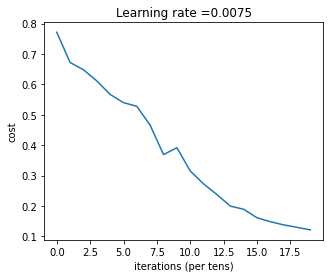

In [37]:
# 设置好深度神经网络的层次信息——下面代表了一个4层的神经网络（12288是输入层），
# 第一层有20个神经元，第二层有7个神经元...
layers_dims = [12288, 20, 7, 5, 1]

# 根据上面的层次信息来构建一个深度神经网络，并且用之前加载的数据集来训练这个神经网络，得出训练后的参数
parameters = dnn_model(train_x, train_y, layers_dims, num_iterations=2000, print_cost=True)

In [38]:
# 预测函数

def predict(X, parameters):
    # 样本数量
    m = X.shape[1]

    # 神经网络层数 (包括输出层)
    n = len(parameters) // 2

    # 结果
    p = np.zeros((1, m))

    # 进行一次前向传播得到预测结果
    probas, caches = L_model_forward(X, parameters)

    # 将预测结果转换为 0/1
    # 大于 0.5 为 1，反之为 0
    for i in range(probas.shape[1]):
        if (probas[0, i] > 0.5):
            p[0, i] = 1
        else:
            p[0, i] = 0
    
    return p


In [43]:
# 对训练数据集进行预测
pred_train = predict(train_x, parameters)
print("预测准确率是: " + str(np.sum((pred_train == train_y) / train_x.shape[1])))


预测准确率是: 0.9808612440191385


In [44]:
# 对测试数据集进行预测
pred_test = predict(test_x, parameters)
print("预测准确率是: " + str(np.sum((pred_test == test_y) / test_x.shape[1])))


预测准确率是: 0.8
